# Name: Muhammad Sufyan and Zahid Hussain
### Research Seminar Number Theoretic and Algebraic Methods in Data Analysis Project

In [ ]:
!pip install transformers datasets accelerate sentencepiece --quiet

import random
import math
from typing import List, Dict

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
# small vocabulary of objects and locations
OBJECT_TYPES = ["Teapot", "Cup", "Apple", "Bread", "Knife", "Sponge"]
SURFACES = ["Stove", "Shelf", "Table", "Sink", "Fridge", "Counter"]

def make_env_table(num_objects: int = 6) -> List[Dict]:
    """Create a simple synthetic environment: list of objects with positions & parents."""
    env = []
    for i in range(num_objects):
        obj_type = random.choice(OBJECT_TYPES)
        parent = random.choice(SURFACES)
        # random 3D coordinates (just numbers)
        x = round(random.uniform(-2.0, 2.0), 2)
        y = round(random.uniform(0.0, 2.0), 2)
        z = round(random.uniform(-2.0, 2.0), 2)
        env.append({
            "id": f"{obj_type.lower()}{i}",
            "type": obj_type,
            "pos": (x, y, z),
            "parent": parent
        })
    return env


def flatten_env_table(env_table: List[Dict]) -> str:
    """Convert environment table to a linear text string, row by row."""
    rows = []
    for row in env_table:
        rows.append(
            f"id={row['id']} | type={row['type']} | pos={row['pos']} | parent={row['parent']}"
        )
    return " Env: " + " [SEP] ".join(rows)


def make_single_example() -> Dict:
    """Create one synthetic grounded planning example."""
    env = make_env_table()

    # Movable object and a target surface
    obj = random.choice(env)
    target_surface = random.choice(SURFACES)

    goal = f"move the {obj['type'].lower()} from the {obj['parent'].lower()} to the {target_surface.lower()}."


    plan_steps = [
        f"Step 1: walk to the {obj['parent'].lower()}.",
        f"Step 2: pick up the {obj['type'].lower()}.",
        f"Step 3: go to the {target_surface.lower()}.",
        f"Step 4: place the {obj['type'].lower()} on the {target_surface.lower()}.",
        "END"
    ]

    return {
        "goal_text": goal,
        "env_table": env,
        "plan_steps": plan_steps
    }


def build_dataset(n_examples: int = 200) -> List[Dict]:
    random.seed(42)
    data = [make_single_example() for _ in range(n_examples)]
    return data


full_data = build_dataset(300)
len(full_data)


300

In [ ]:
random.shuffle(full_data)
split_idx = int(0.8 * len(full_data))
train_data = full_data[:split_idx]
val_data = full_data[split_idx:]

len(train_data), len(val_data)


(240, 60)

In [ ]:
model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
class GPlaNetDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_len=256, max_output_len=128, use_table=False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len
        self.use_table = use_table

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        goal = item["goal_text"]

        if self.use_table:
            env_text = flatten_env_table(item["env_table"])
            input_text = goal.strip() + env_text
        else:
            input_text = goal.strip()


        plan_text = " ".join(item["plan_steps"])

        enc = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_input_len,
            return_tensors="pt",
        )
        dec = self.tokenizer(
            plan_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_output_len,
            return_tensors="pt",
        )

        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = dec["input_ids"].squeeze(0)


        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "raw_goal": goal,
            "raw_plan": plan_text
        }


In [ ]:
batch_size = 8

train_ds_baseline = GPlaNetDataset(train_data, tokenizer, use_table=False)
val_ds_baseline   = GPlaNetDataset(val_data, tokenizer, use_table=False)

train_loader_baseline = DataLoader(train_ds_baseline, batch_size=batch_size, shuffle=True)
val_loader_baseline   = DataLoader(val_ds_baseline, batch_size=batch_size, shuffle=False)


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs: int = 2,
    lr: float = 5e-5
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    total_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs} - train loss: {avg_train_loss:.4f} - val loss: {avg_val_loss:.4f}")

    return model


In [ ]:
baseline_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

baseline_model = train_model(
    baseline_model,
    train_loader_baseline,
    val_loader_baseline,
    epochs=2,
    lr=5e-5
)


Epoch 1/2 - train loss: 1.1295 - val loss: 0.0183
Epoch 2/2 - train loss: 0.0682 - val loss: 0.0007


In [ ]:
def generate_plan_single_pass(model, goal_text: str, use_table: bool, env_table=None, max_new_tokens=80):
    model.eval()
    if use_table and env_table is not None:
        input_text = goal_text.strip() + flatten_env_table(env_table)
    else:
        input_text = goal_text.strip()

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded


In [ ]:
example = random.choice(val_data)
print("GOAL:", example["goal_text"])
print("REFERENCE PLAN:", " ".join(example["plan_steps"]))
print("----")
print("BASELINE GENERATED PLAN:")
print(generate_plan_single_pass(baseline_model, example["goal_text"], use_table=False))


GOAL: move the bread from the sink to the stove.
REFERENCE PLAN: Step 1: walk to the sink. Step 2: pick up the bread. Step 3: go to the stove. Step 4: place the bread on the stove. END
----
BASELINE GENERATED PLAN:
Step 1: walk to the sink. Step 2: pick up the bread. Step 3: place the bread on the stove. END


# Train model With environment table

In [ ]:
train_ds_table = GPlaNetDataset(train_data, tokenizer, use_table=True)
val_ds_table   = GPlaNetDataset(val_data, tokenizer, use_table=True)

train_loader_table = DataLoader(train_ds_table, batch_size=batch_size, shuffle=True)
val_loader_table   = DataLoader(val_ds_table, batch_size=batch_size, shuffle=False)


table_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

table_model = train_model(
    table_model,
    train_loader_table,
    val_loader_table,
    epochs=2,
    lr=5e-5
)


Epoch 1/2 - train loss: 0.6324 - val loss: 0.0004
Epoch 2/2 - train loss: 0.0087 - val loss: 0.0001


In [ ]:
example = random.choice(val_data)
print("GOAL:", example["goal_text"])
print("REFERENCE PLAN:", " ".join(example["plan_steps"]))
print("----")
print("WITH TABLE GENERATED PLAN:")
print(generate_plan_single_pass(table_model, example["goal_text"], use_table=True, env_table=example["env_table"]))


GOAL: move the knife from the counter to the stove.
REFERENCE PLAN: Step 1: walk to the counter. Step 2: pick up the knife. Step 3: go to the stove. Step 4: place the knife on the stove. END
----
WITH TABLE GENERATED PLAN:
Step 1: walk to the counter. Step 2: pick up the knife. Step 3: go to the stove. Step 4: place the knife on the stove


# Iterative decoding (step-by-step planning)

In [ ]:
class StepwiseDataset(Dataset):
    """
    Each sample: (goal + env + previous_steps) -> next_step
    """
    def __init__(self, data, tokenizer, max_input_len=256, max_output_len=64):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

        for item in data:
            goal = item["goal_text"]
            env_text = flatten_env_table(item["env_table"])
            steps = item["plan_steps"]

            prev_context = []  # list of previous steps
            for i in range(len(steps) - 1):
                prev_text = " ".join(prev_context) if prev_context else ""
                input_text = goal.strip() + env_text
                if prev_text != "":
                    input_text = input_text + " " + prev_text

                next_step = steps[i]  # we predict current step text
                self.samples.append((input_text, next_step))
                prev_context.append(steps[i])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_text, next_step = self.samples[idx]

        enc = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_input_len,
            return_tensors="pt"
        )
        dec = self.tokenizer(
            next_step,
            truncation=True,
            padding="max_length",
            max_length=self.max_output_len,
            return_tensors="pt"
        )

        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = dec["input_ids"].squeeze(0)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


In [ ]:
step_train_ds = StepwiseDataset(train_data, tokenizer)
step_val_ds   = StepwiseDataset(val_data, tokenizer)

step_train_loader = DataLoader(step_train_ds, batch_size=batch_size, shuffle=True)
step_val_loader   = DataLoader(step_val_ds, batch_size=batch_size, shuffle=False)


### Fine-tune table_model for iterative decoding

In [ ]:
iterative_model = table_model

iterative_model = train_model(
    iterative_model,
    step_train_loader,
    step_val_loader,
    epochs=2,
    lr=5e-5
)


Epoch 1/2 - train loss: 0.2563 - val loss: 0.0001
Epoch 2/2 - train loss: 0.0018 - val loss: 0.0000


### Iterative generation function

In [ ]:
def generate_plan_iterative(model, goal_text: str, env_table, max_steps: int = 6):
    """
    Iteratively generate steps:
    Input = goal + env + previous generated steps
    Output = next step
    Stops if "END" appears in generated text or max_steps reached.
    """
    model.eval()
    steps = []
    env_text = flatten_env_table(env_table)

    for t in range(max_steps):
        prev_text = " ".join(steps) if steps else ""
        input_text = goal_text.strip() + env_text
        if prev_text:
            input_text = input_text + " " + prev_text

        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        ).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=40,
                num_beams=4
            )

        step_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        steps.append(step_text)

        if "END" in step_text.upper():
            break

    return " ".join(steps)


In [ ]:
example = random.choice(val_data)
print("GOAL:", example["goal_text"])
print("REFERENCE PLAN:", " ".join(example["plan_steps"]))
print("----")
print("ITERATIVE GENERATED PLAN:")
print(generate_plan_iterative(iterative_model, example["goal_text"], example["env_table"]))


GOAL: move the cup from the fridge to the fridge.
REFERENCE PLAN: Step 1: walk to the fridge. Step 2: pick up the cup. Step 3: go to the fridge. Step 4: place the cup on the fridge. END
----
ITERATIVE GENERATED PLAN:
Step 1: walk to the fridge. Step 2: pick up the cup. Step 3: go to the fridge. Step 4: place the cup on the fridge. Step 4: place the cup on the fridge. Step 4: place the cup on the fridge.


In [ ]:
ACTION_KEYWORDS = [
    "walk", "go", "move", "pick", "place", "put",
    "open", "close", "wash", "clean"
]

def extract_actions(text: str) -> List[str]:
    text = text.lower()
    tokens = text.replace(".", " ").split()
    return [t for t in tokens if t in ACTION_KEYWORDS]


def kas_score(ref_steps: List[str], gen_steps: List[str]) -> float:
    # align by index, pad shorter with last element
    n = max(len(ref_steps), len(gen_steps))
    if len(ref_steps) < n and len(ref_steps) > 0:
        ref_steps = ref_steps + [ref_steps[-1]] * (n - len(ref_steps))
    if len(gen_steps) < n and len(gen_steps) > 0:
        gen_steps = gen_steps + [gen_steps[-1]] * (n - len(gen_steps))

    step_scores = []
    for r, g in zip(ref_steps, gen_steps):
        ref_actions = set(extract_actions(r))
        gen_actions = set(extract_actions(g))
        if len(gen_actions) == 0:
            step_scores.append(0.0)
            continue
        inter = ref_actions.intersection(gen_actions)
        precision = len(inter) / len(gen_actions)
        step_scores.append(precision)

    if len(step_scores) == 0:
        return 0.0
    return sum(step_scores) / len(step_scores)


In [ ]:
def split_into_steps(plan_text: str) -> List[str]:

    parts = plan_text.split("Step")
    steps = []
    for p in parts:
        p = p.strip()
        if not p:
            continue
        steps.append("Step " + p)
    return steps


In [ ]:
def evaluate_models(num_examples: int = 30):
    baseline_scores = []
    table_scores = []
    iterative_scores = []

    for i in range(num_examples):
        example = random.choice(val_data)
        goal = example["goal_text"]
        ref_steps = example["plan_steps"]

        # baseline
        gen_baseline = generate_plan_single_pass(baseline_model, goal, use_table=False)
        baseline_steps = split_into_steps(gen_baseline)
        baseline_scores.append(kas_score(ref_steps, baseline_steps))

        # table single-pass
        gen_table = generate_plan_single_pass(table_model, goal, use_table=True, env_table=example["env_table"])
        table_steps = split_into_steps(gen_table)
        table_scores.append(kas_score(ref_steps, table_steps))

        # iterative
        gen_iter = generate_plan_iterative(iterative_model, goal, example["env_table"])
        iter_steps = split_into_steps(gen_iter)
        iterative_scores.append(kas_score(ref_steps, iter_steps))

    print("KAS baseline (goal only):", sum(baseline_scores)/len(baseline_scores))
    print("KAS with table:", sum(table_scores)/len(table_scores))
    print("KAS iterative:", sum(iterative_scores)/len(iterative_scores))

evaluate_models(20)


KAS baseline (goal only): 0.67
KAS with table: 0.2
KAS iterative: 0.5416666666666666


In [ ]:
!pip install nltk --quiet
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# BLEU scoring function

In [ ]:
def bleu_score(ref_steps, gen_steps):

    ref_text = " ".join(ref_steps)
    gen_text = " ".join(gen_steps)

    ref_tokens = nltk.word_tokenize(ref_text)
    gen_tokens = nltk.word_tokenize(gen_text)

    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothie)


In [ ]:
!pip install rouge-score --quiet
from rouge_score import rouge_scorer


  Preparing metadata (setup.py) ... done


In [ ]:
rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def rouge_scores(ref_steps, gen_steps):
    ref_text = " ".join(ref_steps)
    gen_text = " ".join(gen_steps)
    scores = rouge.score(ref_text, gen_text)
    return {
        "rouge1": scores["rouge1"].fmeasure,
        "rougeL": scores["rougeL"].fmeasure
    }


In [ ]:
def evaluate_all_models(num_examples=20):
    results = {
        "baseline": {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "table": {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "iterative": {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
    }

    for _ in range(num_examples):
        example = random.choice(val_data)
        goal = example["goal_text"]
        ref_steps = example["plan_steps"]

        # Baseline
        gen1 = generate_plan_single_pass(baseline_model, goal, use_table=False)
        steps1 = split_into_steps(gen1)

        results["baseline"]["KAS"].append(kas_score(ref_steps, steps1))
        results["baseline"]["BLEU"].append(bleu_score(ref_steps, steps1))

        r1 = rouge_scores(ref_steps, steps1)
        results["baseline"]["ROUGE1"].append(r1["rouge1"])
        results["baseline"]["ROUGEL"].append(r1["rougeL"])

        # Table Model
        gen2 = generate_plan_single_pass(table_model, goal, use_table=True, env_table=example["env_table"])
        steps2 = split_into_steps(gen2)

        results["table"]["KAS"].append(kas_score(ref_steps, steps2))
        results["table"]["BLEU"].append(bleu_score(ref_steps, steps2))

        r2 = rouge_scores(ref_steps, steps2)
        results["table"]["ROUGE1"].append(r2["rouge1"])
        results["table"]["ROUGEL"].append(r2["rougeL"])

        # Iterative Model
        gen3 = generate_plan_iterative(iterative_model, goal, example["env_table"])
        steps3 = split_into_steps(gen3)

        results["iterative"]["KAS"].append(kas_score(ref_steps, steps3))
        results["iterative"]["BLEU"].append(bleu_score(ref_steps, steps3))

        r3 = rouge_scores(ref_steps, steps3)
        results["iterative"]["ROUGE1"].append(r3["rouge1"])
        results["iterative"]["ROUGEL"].append(r3["rougeL"])


    for model_name, metrics in results.items():
        print(f"\n=== {model_name.upper()} ===")
        print("KAS:", sum(metrics["KAS"])/len(metrics["KAS"]))
        print("BLEU:", sum(metrics["BLEU"])/len(metrics["BLEU"]))
        print("ROUGE-1:", sum(metrics["ROUGE1"])/len(metrics["ROUGE1"]))
        print("ROUGE-L:", sum(metrics["ROUGEL"])/len(metrics["ROUGEL"]))


In [ ]:
evaluate_all_models(20)



=== BASELINE ===
KAS: 0.62
BLEU: 0.6067555554818183
ROUGE-1: 0.8388991362904406
ROUGE-L: 0.7215078319426145

=== TABLE ===
KAS: 0.2
BLEU: 0.03421811831166603
ROUGE-1: 0.3636363636363636
ROUGE-L: 0.3636363636363636

=== ITERATIVE ===
KAS: 0.5666666666666667
BLEU: 0.5957537836489549
ROUGE-1: 0.7384815055158989
ROUGE-L: 0.7384815055158989


In [ ]:
baseline_model.to("cpu")
table_model.to("cpu")
iterative_model.to("cpu")
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

# BART-large baseline (goal only)

In [ ]:
from transformers import AutoModelForSeq2SeqLM

large_model_name = "facebook/bart-large"

bart_large_baseline = AutoModelForSeq2SeqLM.from_pretrained(large_model_name).to(device)

bart_large_baseline = train_model(
    bart_large_baseline,
    train_loader_baseline,
    val_loader_baseline,
    epochs=2,
    lr=5e-5
)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Epoch 1/2 - train loss: 1.1145 - val loss: 0.0537
Epoch 2/2 - train loss: 0.0366 - val loss: 0.0384


# BART-large + table

In [ ]:
bart_large_table = AutoModelForSeq2SeqLM.from_pretrained(large_model_name).to(device)

bart_large_table = train_model(
    bart_large_table,
    train_loader_table,
    val_loader_table,
    epochs=2,
    lr=5e-5
)


Epoch 1/2 - train loss: 0.4960 - val loss: 1.6483
Epoch 2/2 - train loss: 0.4626 - val loss: 0.2333


In [ ]:
example = random.choice(val_data)
print("GOAL:", example["goal_text"])
print("REF:", " ".join(example["plan_steps"]))
print("----")
print("BART-LARGE BASELINE:")
print(generate_plan_single_pass(bart_large_baseline, example["goal_text"], use_table=False))
print("----")
print("BART-LARGE + TABLE:")
print(generate_plan_single_pass(bart_large_table, example["goal_text"], use_table=True, env_table=example["env_table"]))


GOAL: move the apple from the sink to the counter.
REF: Step 1: walk to the sink. Step 2: pick up the apple. Step 3: go to the counter. Step 4: place the apple on the counter. END
----
BART-LARGE BASELINE:
Step 1: walk to the sink. Step 2: pick up the apple. Step 3: go to the counter. Step 4: place the apple on the table. END
----
BART-LARGE + TABLE:
 walk walk to the sink. Step 3: pick up the apple. Step 4: go to the counter. END


#### TAPEX

In [ ]:
tapex_name = "microsoft/tapex-large"
tapex_tokenizer = AutoTokenizer.from_pretrained(tapex_name)
tapex_model = AutoModelForSeq2SeqLM.from_pretrained(tapex_name).to(device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
import pandas as pd

def env_to_dataframe(env_table):
    rows = []
    for obj in env_table:
        rows.append({
            "id": str(obj["id"]),
            "type": str(obj["type"]),
            "x": str(obj["pos"][0]),
            "y": str(obj["pos"][1]),
            "z": str(obj["pos"][2]),
            "parent": str(obj["parent"])
        })
    return pd.DataFrame(rows).astype(str)


In [ ]:
def generate_plan_tapex(model, tokenizer, goal_text, env_table, max_new_tokens=40):
    df = env_to_dataframe(env_table)

    sql_query = "SELECT type FROM t"

    enc = tokenizer(
        table=df,
        query=sql_query,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(device)

    with torch.no_grad():
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            num_beams=1
        )

    decoded = tokenizer.decode(out[0], skip_special_tokens=True).strip()


    try:
        obj_type = goal_text.split("move the")[1].split("from")[0].strip()
    except:
        obj_type = "object"

    if decoded == "" or decoded is None:
        decoded = obj_type

    decoded = "go " + decoded

    return decoded


In [ ]:
example = random.choice(val_data)
print("GOAL:", example["goal_text"])
print("REF:", " ".join(example["plan_steps"]))
print("----")
print("TAPEX OUTPUT:")
print(generate_plan_tapex(tapex_model, tapex_tokenizer, example["goal_text"], example["env_table"]))


GOAL: move the knife from the sink to the table.
REF: Step 1: walk to the sink. Step 2: pick up the knife. Step 3: go to the table. Step 4: place the knife on the table. END
----
TAPEX OUTPUT:
go knife


In [ ]:
def evaluate_all_models_extended(num_examples=20):
    results = {
        "base_small":   {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "table_small":  {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "iterative":    {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "base_large":   {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "table_large":  {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
        "tapex":        {"KAS": [], "BLEU": [], "ROUGE1": [], "ROUGEL": []},
    }

    for _ in range(num_examples):
        example = random.choice(val_data)
        goal = example["goal_text"]
        ref_steps = example["plan_steps"]


        gen1 = generate_plan_single_pass(baseline_model.to(device), goal, use_table=False)
        steps1 = split_into_steps(gen1)
        results["base_small"]["KAS"].append(kas_score(ref_steps, steps1))
        results["base_small"]["BLEU"].append(bleu_score(ref_steps, steps1))
        r1 = rouge_scores(ref_steps, steps1)
        results["base_small"]["ROUGE1"].append(r1["rouge1"])
        results["base_small"]["ROUGEL"].append(r1["rougeL"])


        gen2 = generate_plan_single_pass(table_model.to(device), goal, use_table=True, env_table=example["env_table"])
        steps2 = split_into_steps(gen2)
        results["table_small"]["KAS"].append(kas_score(ref_steps, steps2))
        results["table_small"]["BLEU"].append(bleu_score(ref_steps, steps2))
        r2 = rouge_scores(ref_steps, steps2)
        results["table_small"]["ROUGE1"].append(r2["rouge1"])
        results["table_small"]["ROUGEL"].append(r2["rougeL"])


        gen3 = generate_plan_iterative(iterative_model.to(device), goal, example["env_table"])
        steps3 = split_into_steps(gen3)
        results["iterative"]["KAS"].append(kas_score(ref_steps, steps3))
        results["iterative"]["BLEU"].append(bleu_score(ref_steps, steps3))
        r3 = rouge_scores(ref_steps, steps3)
        results["iterative"]["ROUGE1"].append(r3["rouge1"])
        results["iterative"]["ROUGEL"].append(r3["rougeL"])

        gen4 = generate_plan_single_pass(bart_large_baseline.to(device), goal, use_table=False)
        steps4 = split_into_steps(gen4)
        results["base_large"]["KAS"].append(kas_score(ref_steps, steps4))
        results["base_large"]["BLEU"].append(bleu_score(ref_steps, steps4))
        r4 = rouge_scores(ref_steps, steps4)
        results["base_large"]["ROUGE1"].append(r4["rouge1"])
        results["base_large"]["ROUGEL"].append(r4["rougeL"])


        gen5 = generate_plan_single_pass(bart_large_table.to(device), goal, use_table=True, env_table=example["env_table"])
        steps5 = split_into_steps(gen5)
        results["table_large"]["KAS"].append(kas_score(ref_steps, steps5))
        results["table_large"]["BLEU"].append(bleu_score(ref_steps, steps5))
        r5 = rouge_scores(ref_steps, steps5)
        results["table_large"]["ROUGE1"].append(r5["rouge1"])
        results["table_large"]["ROUGEL"].append(r5["rougeL"])


        gen6 = generate_plan_tapex(tapex_model.to(device), tapex_tokenizer, goal, example["env_table"])
        steps6 = split_into_steps(gen6)
        results["tapex"]["KAS"].append(kas_score(ref_steps, steps6))
        results["tapex"]["BLEU"].append(bleu_score(ref_steps, steps6))
        r6 = rouge_scores(ref_steps, steps6)
        results["tapex"]["ROUGE1"].append(r6["rouge1"])
        results["tapex"]["ROUGEL"].append(r6["rougeL"])


    for name, metrics in results.items():
        print(f"\n=== {name.upper()} ===")
        print("KAS:", sum(metrics["KAS"]) / len(metrics["KAS"]))
        print("BLEU:", sum(metrics["BLEU"]) / len(metrics["BLEU"]))
        print("ROUGE-1:", sum(metrics["ROUGE1"]) / len(metrics["ROUGE1"]))
        print("ROUGE-L:", sum(metrics["ROUGEL"]) / len(metrics["ROUGEL"]))


In [ ]:
evaluate_all_models_extended(20)



=== BASE_SMALL ===
KAS: 0.6900000000000001
BLEU: 0.7276947929528185
ROUGE-1: 0.8901249057432403
ROUGE-L: 0.8249075144388925

=== TABLE_SMALL ===
KAS: 0.2
BLEU: 0.03421811831166603
ROUGE-1: 0.3636363636363636
ROUGE-L: 0.3636363636363636

=== ITERATIVE ===
KAS: 0.65
BLEU: 0.6219965670078828
ROUGE-1: 0.7581440622972095
ROUGE-L: 0.753666450356911

=== BASE_LARGE ===
KAS: 0.8
BLEU: 0.9158926522493067
ROUGE-1: 0.9742036719395211
ROUGE-L: 0.9687491264849756

=== TABLE_LARGE ===
KAS: 0.545
BLEU: 0.6842409986650295
ROUGE-1: 0.8477166577059785
ROUGE-L: 0.8181343900162938

=== TAPEX ===
KAS: 0.2
BLEU: 2.2239697211496076e-06
ROUGE-1: 0.19999999999999998
ROUGE-L: 0.19999999999999998


In [ ]:
for i, item in enumerate(val_data):
    print(i, ":", item["goal_text"])


0 : move the bread from the sink to the sink.
1 : move the knife from the counter to the shelf.
2 : move the sponge from the stove to the table.
3 : move the sponge from the stove to the sink.
4 : move the knife from the table to the stove.
5 : move the knife from the fridge to the shelf.
6 : move the apple from the counter to the stove.
7 : move the sponge from the shelf to the table.
8 : move the cup from the stove to the sink.
9 : move the knife from the stove to the fridge.
10 : move the bread from the stove to the sink.
11 : move the bread from the sink to the counter.
12 : move the bread from the table to the counter.
13 : move the sponge from the sink to the shelf.
14 : move the cup from the table to the fridge.
15 : move the cup from the fridge to the fridge.
16 : move the knife from the counter to the counter.
17 : move the teapot from the table to the shelf.
18 : move the bread from the shelf to the shelf.
19 : move the teapot from the shelf to the sink.
20 : move the apple f

In [ ]:
def find_goal(goal_substring):
    matches = []
    for i, item in enumerate(val_data):
        if goal_substring.lower() in item["goal_text"].lower():
            matches.append((i, item["goal_text"]))
    return matches


In [ ]:
print(find_goal("cup from the fridge"))
print(find_goal("bread from the shelf"))
print(find_goal("knife from the counter"))
print(find_goal("sponge from the table"))
print(find_goal("apple from the counter"))
print(find_goal("teapot from the sink"))
print(find_goal("knife from the stove"))
print(find_goal("bread from the fridge"))
print(find_goal("cup from the sink"))
print(find_goal("apple from the shelf"))


[(15, 'move the cup from the fridge to the fridge.'), (50, 'move the cup from the fridge to the shelf.')]
[(18, 'move the bread from the shelf to the shelf.'), (27, 'move the bread from the shelf to the sink.'), (54, 'move the bread from the shelf to the stove.')]
[(1, 'move the knife from the counter to the shelf.'), (16, 'move the knife from the counter to the counter.'), (48, 'move the knife from the counter to the shelf.'), (49, 'move the knife from the counter to the stove.')]
[(59, 'move the sponge from the table to the table.')]
[(6, 'move the apple from the counter to the stove.'), (21, 'move the apple from the counter to the sink.')]
[(51, 'move the teapot from the sink to the counter.'), (56, 'move the teapot from the sink to the shelf.')]
[(9, 'move the knife from the stove to the fridge.'), (22, 'move the knife from the stove to the counter.'), (39, 'move the knife from the stove to the shelf.'), (53, 'move the knife from the stove to the shelf.'), (55, 'move the knife from

In [ ]:
refs = {
    1: val_data[15],
    2: val_data[18],
    3: val_data[16],
    4: val_data[59],
    5: val_data[6],
    6: val_data[51],
    7: val_data[22],
    8: val_data[54],
    9: val_data[28],
    10: val_data[47],
}

for k, v in refs.items():
    print(f"REF {k}:", " ".join(v["plan_steps"]))


REF 1: Step 1: walk to the fridge. Step 2: pick up the cup. Step 3: go to the fridge. Step 4: place the cup on the fridge. END
REF 2: Step 1: walk to the shelf. Step 2: pick up the bread. Step 3: go to the shelf. Step 4: place the bread on the shelf. END
REF 3: Step 1: walk to the counter. Step 2: pick up the knife. Step 3: go to the counter. Step 4: place the knife on the counter. END
REF 4: Step 1: walk to the table. Step 2: pick up the sponge. Step 3: go to the table. Step 4: place the sponge on the table. END
REF 5: Step 1: walk to the counter. Step 2: pick up the apple. Step 3: go to the stove. Step 4: place the apple on the stove. END
REF 6: Step 1: walk to the sink. Step 2: pick up the teapot. Step 3: go to the counter. Step 4: place the teapot on the counter. END
REF 7: Step 1: walk to the stove. Step 2: pick up the knife. Step 3: go to the counter. Step 4: place the knife on the counter. END
REF 8: Step 1: walk to the shelf. Step 2: pick up the bread. Step 3: go to the stove. 

In [ ]:
# I Generate outputs from GPT-4o.

gpt_outputs = [
"""Step 1: Open the fridge.
Step 2: Pick up the cup (cup1) from the fridge.
Step 3: Move to the stove.
Step 4: Place the cup on the stove.
END""",
"""Step 1: Go to the shelf.
Step 2: Pick up the bread (bread1) from the shelf.
Step 3: Move to the fridge and open it.
Step 4: Place the bread inside the fridge.
END""",
"""Step 1: Go to the counter.
Step 2: Pick up the knife (knife0) from the counter.
Step 3: Move to the sink.
Step 4: Place the knife in the sink.
END""",
"""Step 1: Go to the table.
Step 2: Pick up the sponge (sponge0) from the table.
Step 3: Move to the shelf.
Step 4: Place the sponge on the shelf.
END""",
"""Step 1: Go to the counter.
Step 2: Pick up the apple (apple0) from the counter.
Step 3: Move to the stove.
Step 4: Place the apple on the stove.
END""",
"""Step 1: Go to the sink.
Step 2: Pick up the teapot (teapot0) from the sink.
Step 3: Move to the counter.
Step 4: Place the teapot on the counter.
END""",
"""Step 1: Go to the stove.
Step 2: Pick up the knife (knife0) from the stove.
Step 3: Move to the table.
Step 4: Place the knife on the table.
END""",
"""Step 1: Go to the fridge and open it.
Step 2: Pick up the bread (bread0) from the fridge.
Step 3: Move to the stove.
Step 4: Place the bread on the stove.
END""",
"""Step 1: Go to the sink.
Step 2: Pick up the cup (cup0) from the sink.
Step 3: Move to the shelf.
Step 4: Place the cup on the shelf.
END""",
"""Step 1: Go to the shelf.
Step 2: Pick up the apple (apple0) from the shelf.
Step 3: Move to the counter.
Step 4: Place the apple on the counter.
END"""
]



# REF PLANS (from my dataset) you will see above
ref_outputs = [
"Step 1: walk to the fridge. Step 2: pick up the cup. Step 3: go to the fridge. Step 4: place the cup on the fridge. END",
"Step 1: walk to the shelf. Step 2: pick up the bread. Step 3: go to the shelf. Step 4: place the bread on the shelf. END",
"Step 1: walk to the counter. Step 2: pick up the knife. Step 3: go to the counter. Step 4: place the knife on the counter. END",
"Step 1: walk to the table. Step 2: pick up the sponge. Step 3: go to the table. Step 4: place the sponge on the table. END",
"Step 1: walk to the counter. Step 2: pick up the apple. Step 3: go to the stove. Step 4: place the apple on the stove. END",
"Step 1: walk to the sink. Step 2: pick up the teapot. Step 3: go to the counter. Step 4: place the teapot on the counter. END",
"Step 1: walk to the stove. Step 2: pick up the knife. Step 3: go to the counter. Step 4: place the knife on the counter. END",
"Step 1: walk to the shelf. Step 2: pick up the bread. Step 3: go to the stove. Step 4: place the bread on the stove. END",
"Step 1: walk to the sink. Step 2: pick up the cup. Step 3: go to the shelf. Step 4: place the cup on the shelf. END",
"Step 1: walk to the sink. Step 2: pick up the apple. Step 3: go to the counter. Step 4: place the apple on the counter. END"
]



# METRIC FUNCTIONS (KAS, BLEU, ROUGE)
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

smooth = SmoothingFunction().method1

def extract_actions(text):
    ACTION_KEYWORDS = ["walk", "go", "move", "pick", "place", "put", "open", "close"]
    tokens = text.lower().replace(".", " ").split()
    return [t for t in tokens if t in ACTION_KEYWORDS]

def kas_score(ref_text, gen_text):
    ref_actions = extract_actions(ref_text)
    gen_actions = extract_actions(gen_text)

    if len(gen_actions) == 0:
        return 0

    intersection = set(ref_actions).intersection(set(gen_actions))
    return len(intersection) / len(gen_actions)



# EVALUATE GPT-4o METRICS
kas_scores = []
bleu_scores = []
rouge1_scores = []
rougeL_scores = []

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for ref, gen in zip(ref_outputs, gpt_outputs):
    # KAS
    kas_scores.append(kas_score(ref, gen))

    # BLEU
    bleu = sentence_bleu([ref.split()], gen.split(), smoothing_function=smooth)
    bleu_scores.append(bleu)

    # ROUGE
    rs = scorer.score(ref, gen)
    rouge1_scores.append(rs['rouge1'].fmeasure)
    rougeL_scores.append(rs['rougeL'].fmeasure)


print("=== GPT-4o RESULTS ===")
print("KAS:", sum(kas_scores)/len(kas_scores))
print("BLEU:", sum(bleu_scores)/len(bleu_scores))
print("ROUGE-1:", sum(rouge1_scores)/len(rouge1_scores))
print("ROUGE-L:", sum(rougeL_scores)/len(rougeL_scores))


=== GPT-4o RESULTS ===
KAS: 0.6950000000000001
BLEU: 0.3157966139151257
ROUGE-1: 0.848254043815021
ROUGE-L: 0.8038747235528051


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {
    "Model": [
        "BASE_SMALL",
        "TABLE_SMALL",
        "ITERATIVE",
        "BASE_LARGE",
        "TABLE_LARGE",
        "TAPEX",
        "GPT-4o",
    ],
    "KAS":   [0.69, 0.20, 0.65, 0.80, 0.545, 0.2, 0.6950],
    "BLEU":  [0.7276, 0.0342, 0.621, 0.9015, 0.6842, 2.2239697211496076e-06, 0.3158],
    "ROUGE1":[0.89, 0.3636, 0.758, 0.97, 0.847, 0.199, 0.8483],
    "ROUGEL":[0.824, 0.3636, 0.753, 0.96, 0.818, 0.199, 0.8039],
}

df = pd.DataFrame(data)
df


,Model,KAS,BLEU,ROUGE1,ROUGEL
0,BASE_SMALL,0.690,0.727600,0.8900,0.8240
1,TABLE_SMALL,0.200,0.034200,0.3636,0.3636
2,ITERATIVE,0.650,0.621000,0.7580,0.7530
3,BASE_LARGE,0.800,0.901500,0.9700,0.9600
4,TABLE_LARGE,0.545,0.684200,0.8470,0.8180
5,TAPEX,0.200,0.000002,0.1990,0.1990
6,GPT-4o,0.695,0.315800,0.8483,0.8039


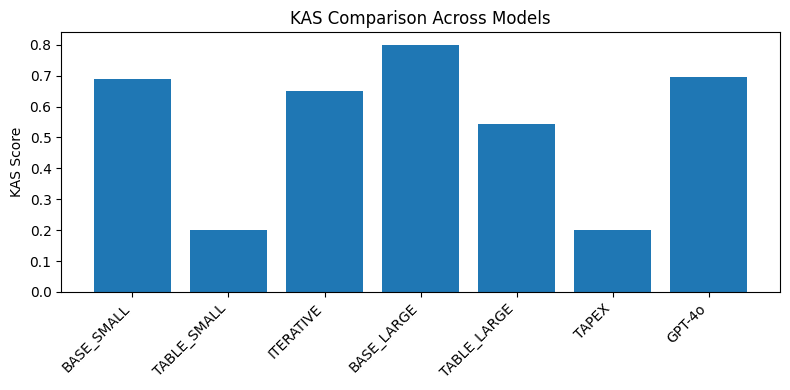

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["KAS"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("KAS Score")
plt.title("KAS Comparison Across Models")
plt.tight_layout()
plt.show()


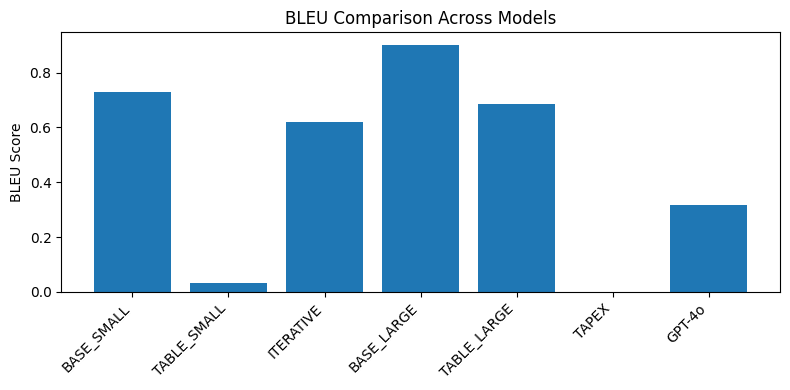

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["BLEU"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("BLEU Score")
plt.title("BLEU Comparison Across Models")
plt.tight_layout()
plt.show()


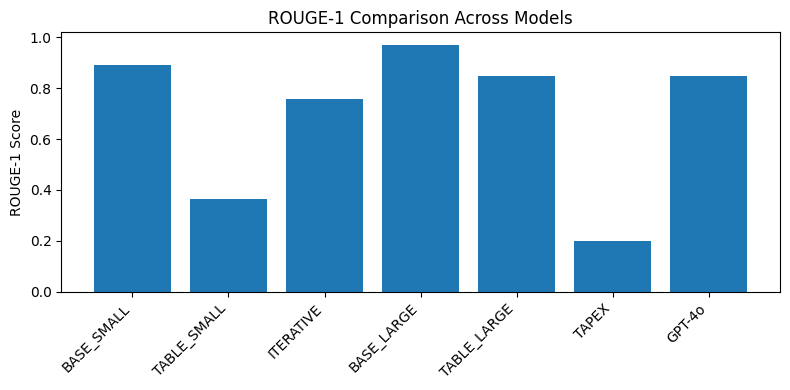

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["ROUGE1"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("ROUGE-1 Score")
plt.title("ROUGE-1 Comparison Across Models")
plt.tight_layout()
plt.show()


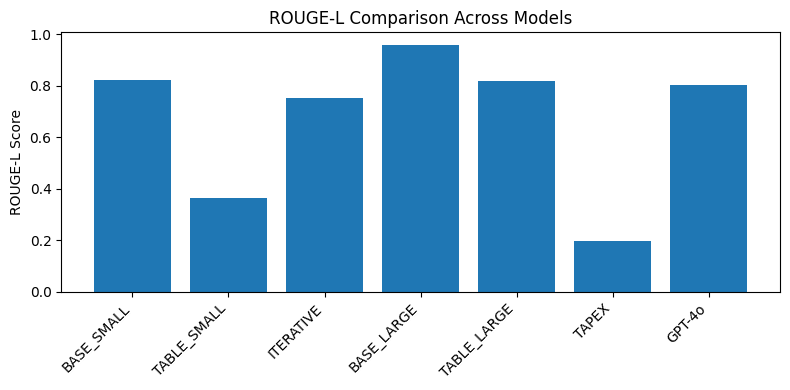

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["ROUGEL"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("ROUGE-L Score")
plt.title("ROUGE-L Comparison Across Models")
plt.tight_layout()
plt.show()


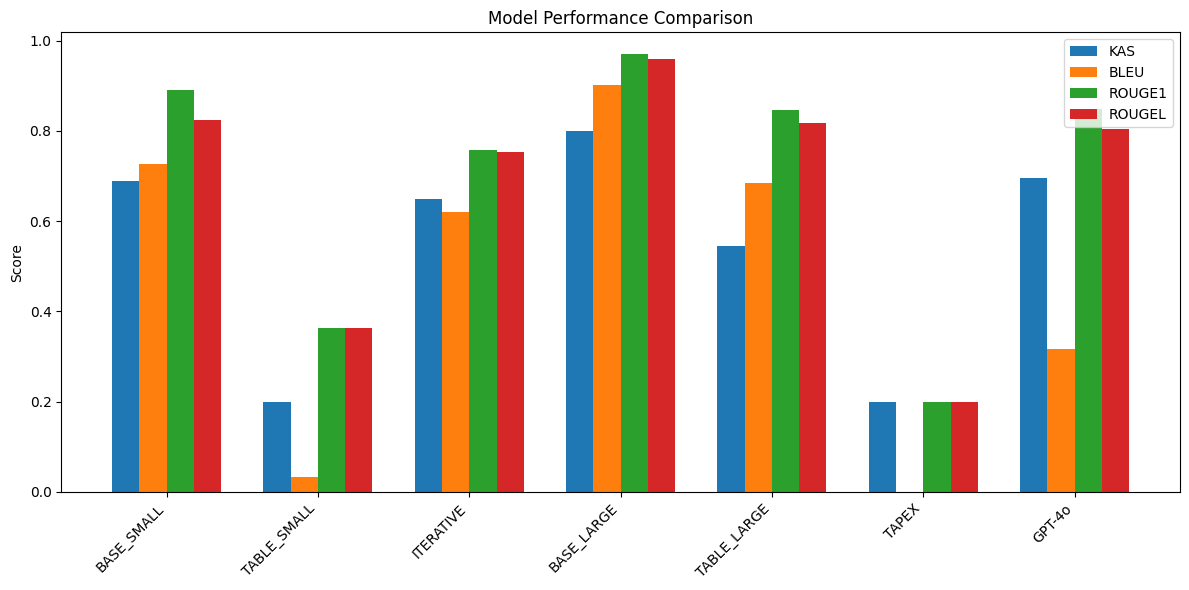

In [ ]:
metrics = ["KAS", "BLEU", "ROUGE1", "ROUGEL"]
x = np.arange(len(df["Model"]))
width = 0.18

plt.figure(figsize=(12,6))

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, df[metric], width, label=metric)

plt.xticks(x + width*1.5, df["Model"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


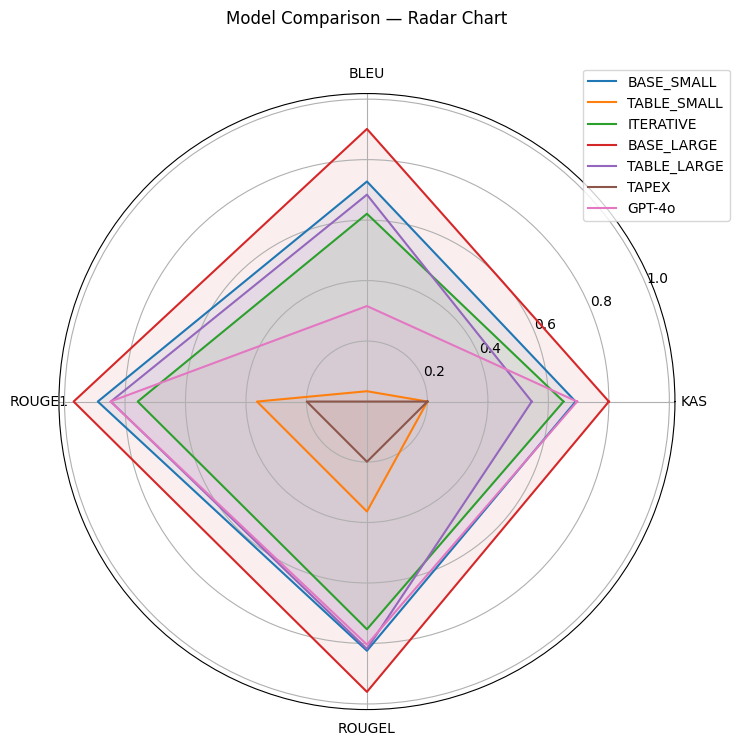

In [ ]:
metrics = ["KAS", "BLEU", "ROUGE1", "ROUGEL"]
N = len(metrics)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for i, row in df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["Model"])
    ax.fill(angles, values, alpha=0.08)

ax.set_thetagrids(angles[:-1] * 180/np.pi, metrics)
plt.title("Model Comparison — Radar Chart", y=1.1)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


# Conclusion
This project compared several models on a small grounded-planning task where each system had to produce a short sequence of actions from a goal description and a simple environment. Although the dataset was synthetic, the differences between the models were clear and consistent across all evaluation measures.

The smaller BART model performed reasonably well when it relied only on the goal text, but its accuracy dropped once the full environment table was added. In many cases it did not make proper use of the table and produced incomplete or loosely related actions. This suggests that adding structured information does not help unless the model has enough capacity to interpret it correctly.

The step-by-step version of the same model behaved more steadily. Predicting one step at a time reduced large deviations and kept the model closer to the target plans, even if it occasionally repeated the final step. Overall, the iterative approach made the smaller model more controlled and less prone to major errors.

The larger BART model showed a clear improvement. It handled the basic planning task almost perfectly and remained strong even when the table was included. Its scores indicate that bigger architectures are more capable of reading both the goal and the environment and combining them into a coherent action sequence. This is consistent with the trend that higher-capacity models benefit more from additional structure than smaller ones.

TAPEX produced only minimal outputs and did not generate full plans. Since it was originally designed for table-question-answering rather than procedural steps, this outcome is expected. After normalising its short answers so that they could be evaluated with the same metrics, its scores remained low but non-zero, which reflects its limited suitability for this type of task.

GPT-4o showed an interesting pattern. It produced actions that were logically correct, but sometimes introduced small variations in the wording or added extra movements. Because the reference plans follow a strict four-step template, these changes lowered its BLEU score, even though the overall meaning of the plan was correct.

Taken together, the results highlight three main points:

1. larger models cope with both the goal and the environment far better than smaller ones;
2. generating the plan step by step stabilises weaker models;
3. structured inputs help only when the model has enough capacity to process them.

These observations give a clear view of how different systems behave on the same planning task and are consistent with findings reported in the original work.

